In [1]:
import pandas_datareader as pdr

In [3]:
df = pdr.get_data_tiingo('AAPL', api_key=key)

C:\Users\Prem Ranjan\anaconda3\envs\tensorflow\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [4]:
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('AAPL.csv')

In [7]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-09-02 00:00:00+00:00,107.73,108.00,106.82,107.70,26802450,25.253828,25.317120,25.040507,25.246795,107209800,0.0,1.0
1,AAPL,2016-09-06 00:00:00+00:00,107.70,108.30,107.51,107.90,26880391,25.246795,25.387446,25.202256,25.293679,107521564,0.0,1.0
2,AAPL,2016-09-07 00:00:00+00:00,108.36,108.76,107.07,107.83,42364328,25.401511,25.495278,25.099112,25.277269,169457312,0.0,1.0
3,AAPL,2016-09-08 00:00:00+00:00,105.52,107.27,105.24,107.25,53002026,24.735764,25.145995,24.670127,25.141307,212008104,0.0,1.0
4,AAPL,2016-09-09 00:00:00+00:00,103.13,105.72,103.13,104.64,46556984,24.175506,24.782648,24.175506,24.529477,186227936,0.0,1.0


In [8]:
df.shape

(1257, 14)

In [9]:
df1 = df.reset_index()['close']
df1.head()

0    107.73
1    107.70
2    108.36
3    105.52
4    103.13
Name: close, dtype: float64

In [10]:
df1.shape

(1257,)

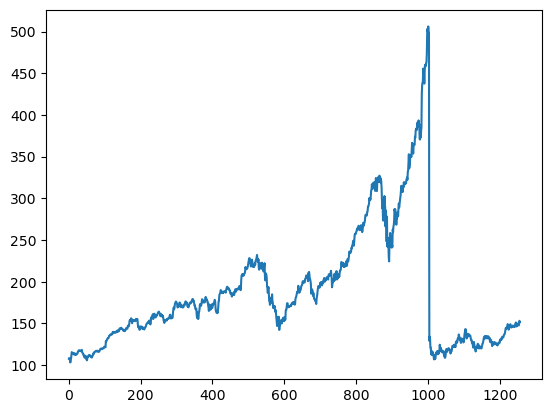

In [11]:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.show()

This graph shows movement in the timespan ranging `2016-2021`

In [12]:
## LSTM is very sensitive to the scale of data, we have apply MinMax Scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1257, 1)

In [13]:
df1[:5]

array([[0.01141553],
       [0.01134108],
       [0.01297896],
       [0.00593111],
       [0.        ]])

In [14]:
## Spliting the training and testing dataset
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [15]:
training_size, test_size

(817, 440)

In [16]:
train_data[:5]

array([[0.01141553],
       [0.01134108],
       [0.01297896],
       [0.00593111],
       [0.        ]])

In [17]:
## converting an array of values into a dataset matrix
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step -1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [18]:
## reshape into X=t,t+1,t+2 and Y=t+4
time_step = 100
X_train,y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train)

[[0.01141553 0.01134108 0.01297896 ... 0.04179075 0.04653067 0.04667957]
 [0.01134108 0.01297896 0.00593111 ... 0.04653067 0.04667957 0.04670439]
 [0.01297896 0.00593111 0.         ... 0.04667957 0.04670439 0.04591026]
 ...
 [0.2404457  0.2434733  0.24841175 ... 0.39428231 0.39371153 0.40510224]
 [0.2434733  0.24841175 0.24473893 ... 0.39371153 0.40510224 0.39994044]
 [0.24841175 0.24473893 0.24858547 ... 0.40510224 0.39994044 0.40875025]]


In [20]:
print(X_test.shape, y_test.shape)

(339, 100) (339,)


In [21]:
print(X_train.shape, y_train.shape)

(716, 100) (716,)


In [22]:
## reshaping input to 3-dimensional for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
print(X_train.shape, X_test.shape)

(716, 100, 1) (339, 100, 1)


In [24]:
## Creating the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [25]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 450ms/step - loss: 0.0098 - val_loss: 0.0379
Epoch 2/100
12/12 [==============================] - 3s 211ms/step - loss: 0.0021 - val_loss: 0.0256
Epoch 3/100
12/12 [==============================] - 4s 319ms/step - loss: 0.0011 - val_loss: 0.0220
Epoch 4/100
12/12 [==============================] - 3s 245ms/step - loss: 6.7366e-04 - val_loss: 0.0211
Epoch 5/100
12/12 [==============================] - 4s 312ms/step - loss: 5.1693e-04 - val_loss: 0.0233
Epoch 6/100
12/12 [==============================] - 3s 257ms/step - loss: 4.8876e-04 - val_loss: 0.0238
Epoch 7/100
12/12 [==============================] - 3s 234ms/step - loss: 5.6113e-04 - val_loss: 0.0235
Epoch 8/100
12/12 [==============================] - 3s 254ms/step - loss: 5.8483e-04 - val_loss: 0.0218
Epoch 9/100
12/12 [==============================] - 3s 228ms/step - loss: 4.5181e-04 - val_loss: 0.0212
Epoch 10/100
12/12 [==============================] - 3s 225ms/step

In [28]:
import tensorflow as tf

In [29]:
## Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [30]:
## Transformation to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [31]:
## Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

181.78698339599669

In [32]:
## TEST DATA
math.sqrt(mean_squared_error(y_test, test_predict))

232.2249309470164

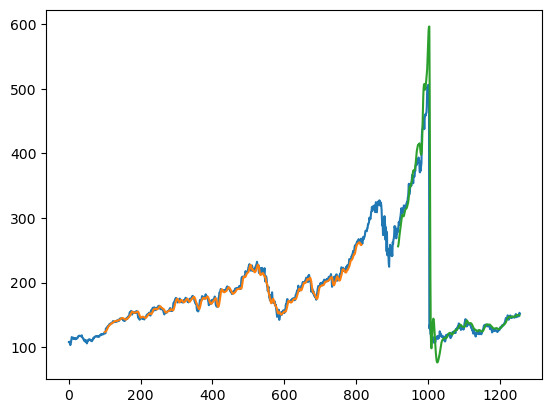

In [33]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
## Now, Lets foreast for next 30 days
len(test_data)

440

In [44]:
## We will take last previous 100 records and predict the next forecast iteratively
x_input = test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [45]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [46]:
temp_input[:5]

[0.06975878499106619,
 0.07767520349414342,
 0.07171927734762762,
 0.07784891800675009,
 0.07700516180266037]

In [47]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.11664689]
101
1 day input [0.0776752  0.07171928 0.07784892 0.07700516 0.07869267 0.07439944
 0.07536728 0.07149593 0.07740222 0.07839488 0.07757594 0.07556581
 0.07531765 0.07030474 0.07298491 0.06134604 0.06196645 0.06603633
 0.0672027  0.0588644  0.05653167 0.04873933 0.05419893 0.06035338
 0.05742505 0.05390113 0.05350407 0.06000596 0.05534048 0.05948481
 0.05898849 0.0588644  0.05496824 0.05330554 0.0524866  0.05442228
 0.05065019 0.05648203 0.05650685 0.05859142 0.05955926 0.05702799
 0.06010522 0.06787274 0.06578817 0.0670538  0.07112368 0.06782311
 0.07238932 0.07655847 0.07586361 0.07514393 0.07439944 0.07854378
 0.08239031 0.08395374 0.08472305 0.09139865 0.09651082 0.10283899
 0.09953842 0.10417907 0.10266528 0.10549434 0.11420488 0.11254219
 0.10735557 0.09757792 0.10675998 0.10489875 0.10837304 0.11274072
 0.11380782 0.10829859 0.10385646 0.10549434 0.1060403  0.10519655
 0.10976276 0.10874528 0.10901826 0.10673516 0.10661108 0.10539508
 0.1060403  0.11355966 0.1140808 

In [49]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [50]:
import matplotlib.pyplot as plt
len(df1)

1257

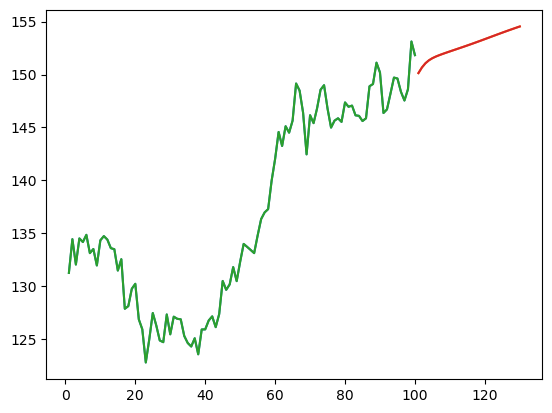

In [52]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.show()

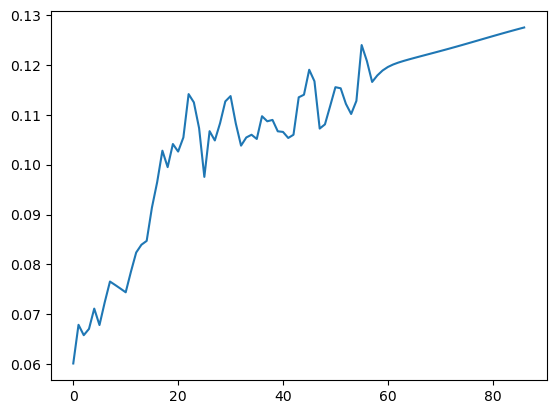

In [53]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])
plt.show()

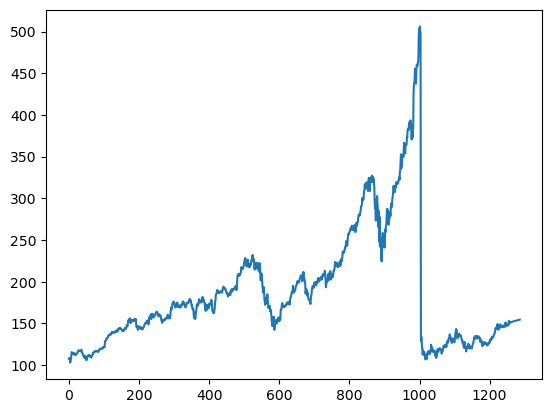

In [54]:
## adding prediction to the original graph
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)
plt.show()